# P-values in ML

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import scipy as sc
import sklearn as sk
import sys
import os

from scipy.stats import chi2
from sklearn.ensemble import RandomForestClassifier
from statsmodels.discrete.discrete_model import Logit

### Create dataset

In [2]:
def logit(h):
    ''' Logistic from activation h '''
    p = 1.0 / (1.0 + np.exp(-h))
    r = np.random.rand(len(p))
    y = (r < p).astype('float')
    return y


def rand_date():
    max_time = int(time.time())
    t = random.randint(0, max_time)
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t))


def rand_unif(num, mean, std, na_prob=0):
    xi = np.random.rand(num)
    if na_prob > 0:
        xi_na = (np.random.rand(num) <= na_prob)
        xi[xi_na] = np.nan
    return xi


def rand_norm(num, mean=0.0, std=1.0, na_prob=0):
    xi = np.random.normal(mean, std, num)
    if na_prob > 0:
        xi_na = (np.random.rand(num) <= na_prob)
        xi[xi_na] = np.nan
    return xi


def rbf(x, mu=0, sigma=1):
    """ Radial basis function """
    z = (x - mu) / sigma
    return np.exp(-(z*z))


def create_dataset_01(num=1000, n_rands=5, save=False):
    """ Create dataset y = f(x1, x2, x3) + noise (r* are not used) """
    x1 = rand_norm(num)
    x2 = rand_norm(num)
    x3 = rand_norm(num)
    n = rand_norm(num)
    y = logit(3.0 * x1 - 2.0 * x2 + 1.0 * x3 + 0.5 * n)
    d = {'x1': x1, 'x2': x2, 'x3': x3, 'y': y}
    for i in range(n_rands):
        d[f"rand_{i}"] = rand_norm(num)
    df = pd.DataFrame(d)
    if save:
        file = 'zzz.csv'
        print(f"Saving dataset to file '{file}'")
        df.to_csv(file, index=False)
    return df

def create_dataset_02(num=1000, n_rands=5, save=False):
    """ Create dataset y = f(x1, x2, x3) + noise (r* are not used) """
    x1 = rand_norm(num)
    x2 = rand_norm(num)
    x3 = rand_norm(num)
    n = rand_norm(num)
    y = logit(5.0 * rbf(x1, 1, 1) - 3.0 * rbf(x2, -1, 1) + 1.0 * x3 + 0.5 * n)
    d = {'x1': x1, 'x2': x2, 'x3': x3, 'y': y}
    for i in range(n_rands):
        d[f"rand_{i}"] = rand_norm(num)
    df = pd.DataFrame(d)
    if save:
        file = 'zzz.csv'
        print(f"Saving dataset to file '{file}'")
        df.to_csv(file, index=False)
    return df

### Feature importance

In [3]:
def wilks_model_fit(x, y):
    logit_model = Logit(y, x)
    res = logit_model.fit(disp=0)
    return logit_model, res

def wilks_p_value(df, var_output, vars_null):
    model_null, model_null_results = wilks_model_fit(df[vars_null], df[var_output])
    pvalues = dict()
    for c in df.columns:
        if c != var_output and c not in vars_null:
            xnames = list(vars_null)
            xnames.append(c)
            model_alt, model_alt_res = wilks_model_fit(df[xnames], df[var_output])
            if model_alt is None:
                self._error(f"Could not fit alt model for column/s {c}")
                pval = 1.0
            else:
                d = 2.0 * (model_alt_res.llf - model_null_results.llf)
                pval = chi2.sf(d, 1)
            pvalues[c] = pval
    return pd.Series(pvalues)

def feature_importance(model, x, y, var):
    score_null = model.score(x, y)
    x_shuf = x.copy()
    x_shuf[var] = x_shuf[var].sample(frac=1).values
    score_alt = model.score(x_shuf, y)
    return (score_null - score_alt) / score_null

def feature_importance_multiple_shuffle(model, x_validate, y_validate, vars_input, num_iter=10, scores=None):
    scores = dict() if scores is None else scores
    for var in vars_input:
        delta_scores = list()
        for i in range(num_iter):
            delta_score = feature_importance(model, x_validate, y_validate, var)
            delta_scores.append(delta_score)
        delta_scores = np.array(delta_scores)
        print(f"\t{var}:\tcount: {len(delta_scores)}\tmean: {delta_scores.mean()}\tstd: {delta_scores.std()}")
        # Append values to array (if any)
        scores[var] = delta_scores if var not in scores else np.append(scores[var], delta_scores).flatten()
    return scores

def split_df(df, var_inputs, var_output, train_index, val_index):
    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    return df_train[var_inputs], df_train[var_output], df_val[var_inputs], df_val[var_output]


### Cross-validations & models

In [4]:
from sklearn.model_selection import KFold

# Create new dataset
def create_dataset(**kwargs): return create_dataset_02(**kwargs)

# Create new model
def new_model(): return RandomForestClassifier(100)

# Create dataset
def p_values_shuffle(num_samples=100, n_rands=5, num_cv=1, num_shuffle=10, show_plot=False, pvals_df=None):
    df = create_dataset(num=num_samples, n_rands=n_rands)
    if show_plot:
        sb.pairplot(df, kind='scatter', diag_kind='kde')
    # Variables
    var_output = 'y'
    vars_input = [c for c in df.columns if c != var_output]
    vars_null = [c for c in vars_input if c.startswith('rand_')]
    # Create several models...
    scores = dict()
    if num_cv > 1:
        cv_iter = KFold(n_splits=num_cv).split(df)
    else:
        # No cross validation, split 80% / 20%
        idx = int(0.8 * len(df))
        idx_train = range(0, idx)
        idx_val = range(idx, len(df))
        cv_iter = [(idx_train, idx_val)]
    cv_count = 0
    for train_index, val_index in cv_iter:
        cv_count += 1
        # print(f"Cross validation: {cv_count} / {num_cv}")
        # Split dataset
        x_train, y_train, x_validate, y_validate = split_df(df, vars_input, var_output, train_index, val_index)
        # Create model
        model = new_model()
        model_fit = model.fit(x_train, y_train)
        # Calculate scores (shuffle)
        scores = feature_importance_multiple_shuffle(model, x_validate, y_validate, vars_input, num_iter=num_shuffle, scores=scores)
    # Calculate p-values
    pvals_df = pd.DataFrame() if pvals_df is None else pvals_df
    null_scores = np.array([scores[c] for c in vars_null]).flatten()
    for c in vars_input:
        null_scores = np.array([scores[cn] for cn in vars_null if cn != c]).flatten()
        pval = sc.stats.mannwhitneyu(scores[c], null_scores, alternative='greater')[1]
        df_row = pd.DataFrame({'name': c,
            'num_samples': num_samples, 'n_rands': n_rands,
            'num_cv': num_cv, 'num_shuffle': num_shuffle,
            'count_alt': len(scores[c])
                      , 'mean_alt': scores[c].mean(), 'std_alt': scores[c].std()
                      , 'count_null': len(null_scores), 'mean_null': null_scores.mean()
                      , 'std_null': null_scores.std()
                      , 'p_value': pval}, index=[len(pvals_df)])
        pvals_df = pvals_df.append(df_row)
    return pvals_df

### P-values analysis

In [5]:
def pvalues_shuffle_analysis():
    pvals_df = None
    for num_cv in [1, 3, 5, 10, 20]:
        for num_samples in [50, 100, 200, 300, 400, 500, 1000, 2000, 10000]:
            for num_shuffle in [3, 5, 10, 20, 50, 100]:
                pvals_df = p_values_shuffle(num_samples=num_samples, n_rands=5, num_cv=num_cv, num_shuffle=num_shuffle, pvals_df=pvals_df)
                print(f"num_cv: {num_cv}\tnum_samples:{num_samples}\tnum_shuffle:{num_shuffle}")
    pvals_df.to_csv('p_values_shuffle.csv')
    return pvals_df

In [6]:
# df = create_dataset_02(num=1000, n_rands=5, save=False)
# # sns.pairplot(df, kind='scatter', diag_kind='kde')
# df.head(20)

In [7]:
# pvals_df = pvalues_shuffle_analysis()
# pvals_df.head(20)

# Results

In [55]:
pvals_df = pd.read_csv('p_values_shuffle_02_RandomForest.csv', index_col=0)
var = 'x2'

In [56]:
pvals_df.head(10)

,name,num_samples,n_rands,num_cv,num_shuffle,count_alt,mean_alt,std_alt,count_null,mean_null,std_null,p_value
0,x1,50,5,1,3,3,0.000000,0.000000,15,0.028571,0.077372,0.775154
1,x2,50,5,1,3,3,0.047619,0.067344,15,0.028571,0.077372,0.387268
2,x3,50,5,1,3,3,-0.095238,0.067344,15,0.028571,0.077372,0.985239
3,rand_0,50,5,1,3,3,0.095238,0.067344,12,0.011905,0.070430,0.058593
4,rand_1,50,5,1,3,3,0.095238,0.067344,12,0.011905,0.070430,0.058593
5,rand_2,50,5,1,3,3,0.000000,0.000000,12,0.035714,0.085017,0.807956
6,rand_3,50,5,1,3,3,0.000000,0.000000,12,0.035714,0.085017,0.807956
7,rand_4,50,5,1,3,3,-0.047619,0.067344,12,0.047619,0.067344,0.966211
8,x1,50,5,1,5,5,0.514286,0.145686,25,-0.057143,0.090351,0.000124
9,x2,50,5,1,5,5,-0.028571,0.106904,25,-0.057143,0.090351,0.311162


In [57]:
dfx = pvals_df[pvals_df.name == var].copy()

x = np.log(dfx.count_alt * dfx.num_samples) / np.log(10)
y = -np.log(dfx.p_value)/np.log(10)

dfx['log_pvalue'] = y
dfx.drop('p_value', axis=1, inplace=True)

dfx.head(10)

,name,num_samples,n_rands,num_cv,num_shuffle,count_alt,mean_alt,std_alt,count_null,mean_null,std_null,log_pvalue
1,x2,50,5,1,3,3,4.761905e-02,0.067344,15,0.028571,0.077372,4.119881e-01
9,x2,50,5,1,5,5,-2.857143e-02,0.106904,25,-0.057143,0.090351,5.070133e-01
17,x2,50,5,1,10,10,-1.833333e-01,0.189297,50,-0.103333,0.148661,1.844302e-02
25,x2,50,5,1,20,20,2.750000e-01,0.115920,100,0.071250,0.118921,8.125553e+00
33,x2,50,5,1,50,50,-2.800000e-01,0.258070,250,-0.100000,0.187083,2.562901e-06
41,x2,50,5,1,100,100,-2.160000e-01,0.178168,500,-0.085600,0.142101,1.976871e-15
49,x2,100,5,1,3,3,2.083333e-02,0.029463,15,0.041667,0.037268,8.371662e-02
57,x2,100,5,1,5,5,1.428571e-02,0.053452,25,0.008571,0.054660,4.057256e-01
65,x2,100,5,1,10,10,6.428571e-02,0.125560,50,-0.010000,0.065481,1.802715e+00
73,x2,100,5,1,20,20,-6.245005e-17,0.098457,100,-0.057143,0.052489,2.611382e+00


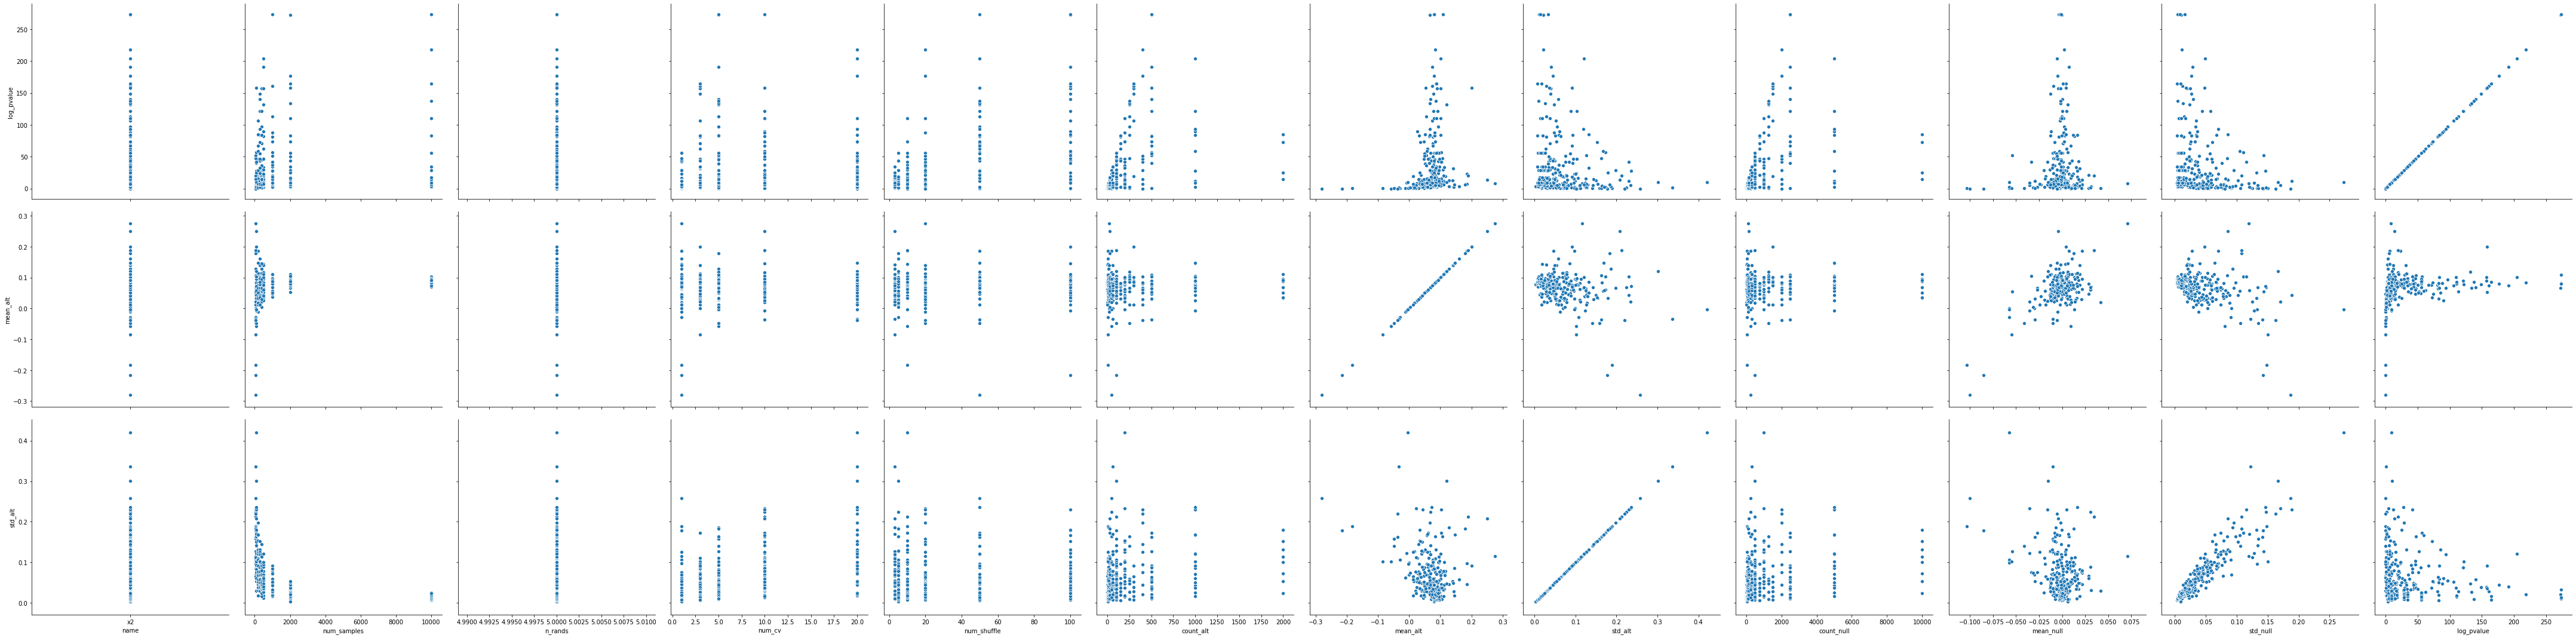

In [58]:
sb.pairplot(dfx, x_vars=list(dfx.columns), y_vars=['log_pvalue', 'mean_alt', 'std_alt'], height=5, kind='scatter', diag_kind='kde')

Summary:
- count_alt: This clearly helps
- count_nulls: This clearly helps

- Num samples: Reduces the 'stdev' of alt/null estimates
- num_cv?
- num_shuffle: Increasing it helps


- TODO: Check that count_alts = num_cv * num_shuffle
- TODO: Plot mean & std vs count_alts / count_nulls

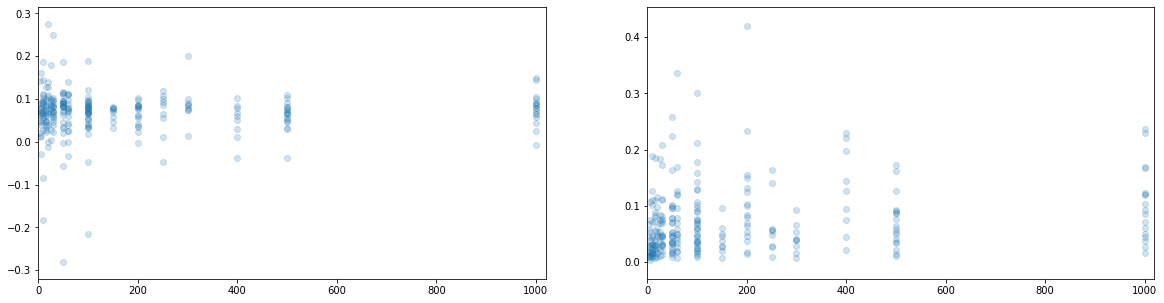

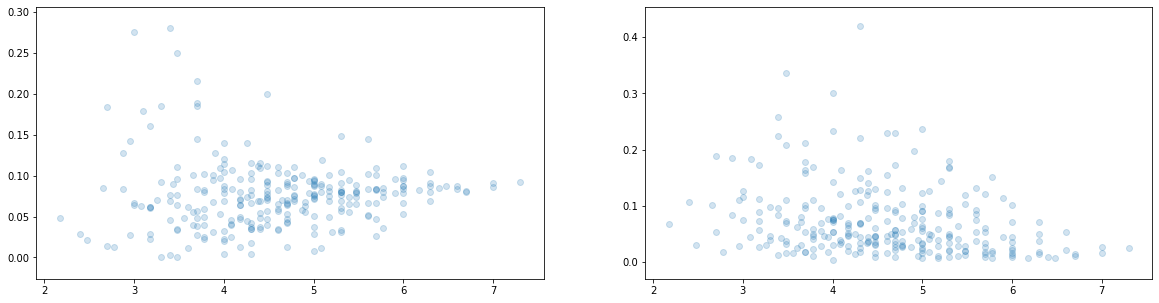

In [59]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.scatter(dfx.count_alt, dfx.mean_alt, alpha=0.2)
axes = plt.gca()
axes.set_xlim([0, 1020])

plt.subplot(122)
plt.scatter(dfx.count_alt, dfx.std_alt, alpha=0.2)
axes = plt.gca()
axes.set_xlim([0, 1020])

#
plt.figure(figsize=(20, 5))


plt.subplot(121)
plt.scatter(x, np.abs(dfx.mean_alt), alpha=0.2)
axes = plt.gca()
# axes.set_xlim([0, 1020])

plt.subplot(122)
plt.scatter(x, dfx.std_alt, alpha=0.2)
axes = plt.gca()
# axes.set_xlim([0, 1020])

(0, 10)

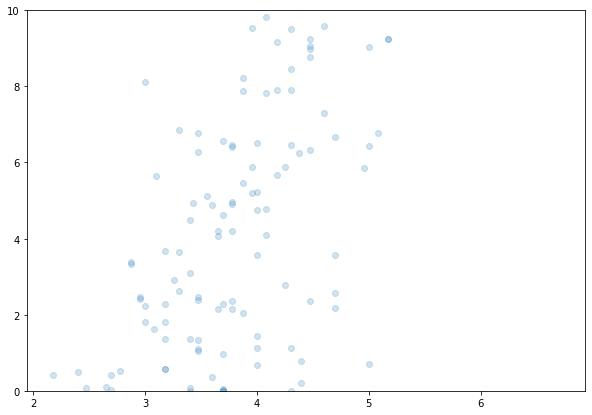

In [60]:
plt.figure(figsize=(10, 7))
plt.scatter(x, dfx['log_pvalue'], alpha=0.2)
axes = plt.gca()
axes.set_ylim([0, 10])

(154, 44, 0.2857142857142857)

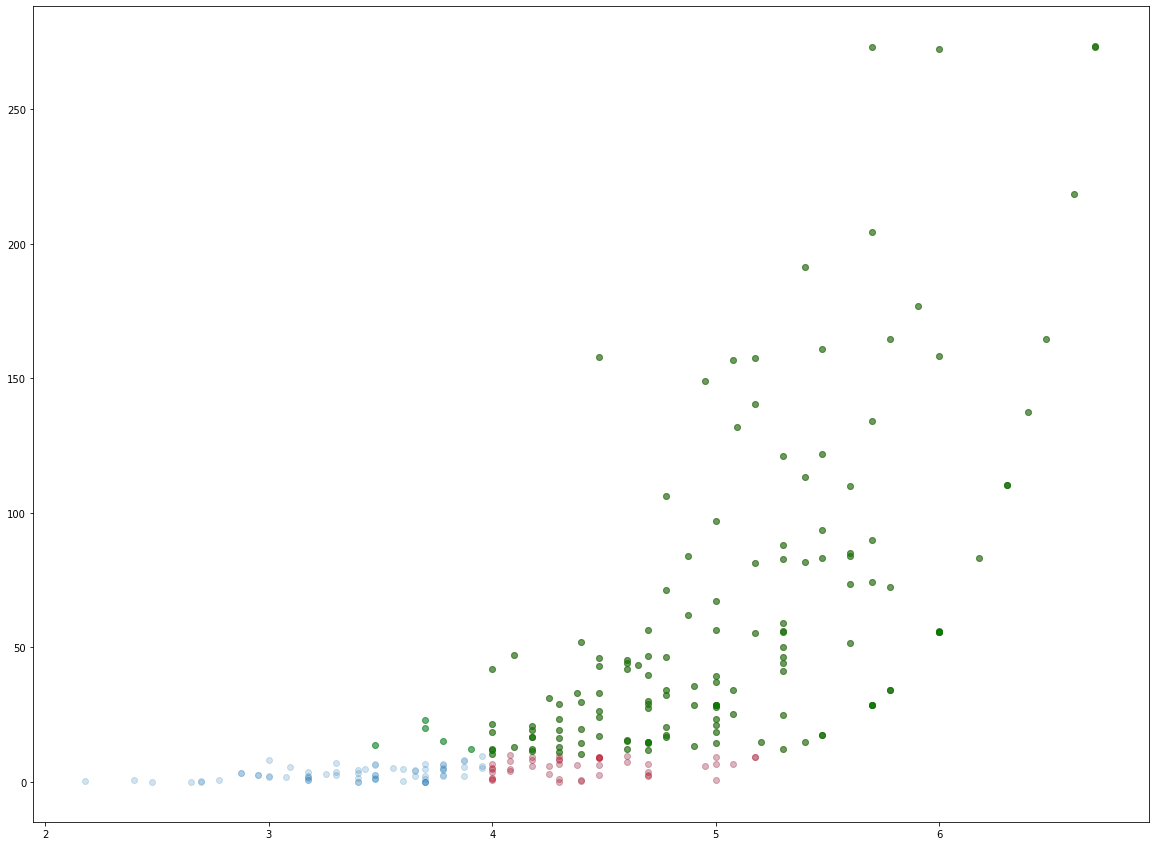

In [61]:
num_th = 10 * 1000
keep = (dfx.num_samples * dfx.num_cv * dfx.num_shuffle) >= num_th

plt.figure(figsize=(20, 15))
plt.scatter(x, y, alpha=0.2)

good = y > 10
plt.scatter(x[keep], y[keep], alpha=0.2, c='r')

plt.scatter(x[good], y[good], alpha=0.5, c='g')
(keep & good).sum(), (keep & ~good).sum(), (keep & ~good).sum() / (keep & good).sum()

In [62]:
# pd.option_context('display.max_rows', 300, 'display.max_columns', 100)
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
dfx[keep]

,name,num_samples,n_rands,num_cv,num_shuffle,count_alt,mean_alt,std_alt,count_null,mean_null,std_null,log_pvalue
89,x2,100,5,1,100,100,0.105000,0.075224,500,-0.033429,0.060650,41.901782
129,x2,200,5,1,50,50,0.032308,0.054044,250,-0.029385,0.045187,11.754686
137,x2,200,5,1,100,100,0.034400,0.070204,500,-0.010000,0.052452,8.446908
177,x2,300,5,1,50,50,0.071837,0.046581,250,0.009061,0.031766,16.461362
185,x2,300,5,1,100,100,0.092400,0.034846,500,0.017480,0.033479,42.991222
225,x2,400,5,1,50,50,0.096364,0.032884,250,0.002303,0.019550,28.927644
233,x2,400,5,1,100,100,0.065667,0.037030,500,-0.002333,0.024039,44.129731
265,x2,500,5,1,20,20,0.139333,0.053079,100,-0.012800,0.018849,12.355605
273,x2,500,5,1,50,50,0.109487,0.037790,250,-0.013128,0.016693,29.486386
281,x2,500,5,1,100,100,0.065405,0.037728,500,-0.009730,0.022828,46.936359


In [63]:
for i in range(100):
    num_th = i * 1000
    keep = (dfx.num_samples * dfx.num_cv * dfx.num_shuffle) >= num_th
    count_bad = (y[keep] < 10).sum()
    print(f"i: {i}\tcount keep: {keep.sum()}\tbad:{count_bad}\t{100 * count_bad/keep.sum()}")

i: 0	count keep: 270	bad:111	41.111111111111114
i: 1	count keep: 259	bad:100	38.61003861003861
i: 2	count keep: 247	bad:88	35.62753036437247
i: 3	count keep: 238	bad:79	33.19327731092437
i: 4	count keep: 229	bad:71	31.004366812227076
i: 5	count keep: 224	bad:66	29.464285714285715
i: 6	count keep: 214	bad:58	27.102803738317757
i: 7	count keep: 206	bad:51	24.75728155339806
i: 8	count keep: 202	bad:47	23.26732673267327
i: 9	count keep: 201	bad:47	23.383084577114428
i: 10	count keep: 198	bad:44	22.22222222222222
i: 11	count keep: 185	bad:37	20.0
i: 12	count keep: 185	bad:37	20.0
i: 13	count keep: 179	bad:33	18.435754189944134
i: 14	count keep: 179	bad:33	18.435754189944134
i: 15	count keep: 179	bad:33	18.435754189944134
i: 16	count keep: 170	bad:30	17.647058823529413
i: 17	count keep: 170	bad:30	17.647058823529413
i: 18	count keep: 170	bad:30	17.647058823529413
i: 19	count keep: 167	bad:28	16.766467065868262
i: 20	count keep: 167	bad:28	16.766467065868262
i: 21	count keep: 155	bad:22	14.19

In [ ]:
keep = (dfx.num_samples * dfx.num_cv * dfx.num_shuffle) >= num_th